## NLP Application with DL

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout # GRU scores are better than LSTM for this data and it's faster.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hepsiburada.zip', encoding="utf-8") # utf-8 due to turkish characters

In [4]:
df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243497 entries, 0 to 243496
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Rating  243497 non-null  int64 
 1   Review  243497 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [7]:
# change the label for target class to 1
df.Rating = df.Rating.map({1:0, 0:1})

# hedef classımızı 1 yapıyoruz. hedef olumsuz yorumlari yakalalmak oldugu icin target labeli 1 yapiyoruz
# sentiment analysis icin best practice target class'in 1 yapilmasidir.

In [8]:
df.Rating.value_counts()
# a veyr imabalnced data


0    229821
1     13676
Name: Rating, dtype: int64

In [9]:
df.Rating.value_counts(normalize=True)

0    0.943835
1    0.056165
Name: Rating, dtype: float64

## Tokenization

In [10]:
X = df['Review']
y = df['Rating']

In [11]:
num_words = 15001 # 1 fazlasını yazıyoruz. Cunku word_index 0'dan degil 1'den baslar

tokenizer = Tokenizer(num_words=num_words,) #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890' # lower default true
# Tokenizer fonksiyonu tüm textleri word tokenlerine ayırır. 
# num_words hyperparametresi tokenlerin numeric versiyona dönüştürülmesi aşamasında sadece corpusta en fazla geçen ilk 15.000 kelime(token)'nin numeric versiyona 
# dönüştürüleceğini diğer tokenlerin ignore edileceğini gösteriyor.
# num_words'e None değeri atanırsa tüm kelimeler/tokenler numeric versiyona dönüştürülür. Ancak num_words'e None atandığında DL modeline data verilirken hata 
# döndürür. Bu sebeple num_words'e herzaman integer sayı atanmalıdır. Model kurma aşamasında detaylarına gireceğiz.

# Classification ve sentiment analysisde 15k veya 20k num_words'un yeterli oldugu calismalarda ortaya cikmistir.
# None olmasi ve 15k-20k olmasi halinde skorlar genelde benzer donuyor. Ama bu computational costu cok azaltir

# filters hyper_parametresiyle yapılacak olan temizlik işlemlerini düzenleyebiliyoruz.

In [12]:
tokenizer.fit_on_texts(X)

# fit_on_texts methodu, önce corpustaki textleri tokenlerine ayırır sonra da tüm unique tokenleri tespit edip kullanım sıklıklarına göre numaralandırır. 
# En sık kullanılan tokene 1 numarası verilir.
# num_words= 15001 tanımladığımız için dönüşüm aşamasında 1 ile 15000 arasındaki numaraları alan tokenler kullanılacak diğerleri ignore edilecek.
# Bu tokenlerin kullanım sıklıklarının sıralamasını görebilmek için aşağıda olduğu gibi word_index fonksiyonunu kullanmamız gerekecek.

## Creating word index

In [13]:
tokenizer.word_index

# word_index corpustaki tokenleri kullanım sıklıklarına göre sıralar. Burda 213k'nin hepsini gosteriyor ama donnusum esnasinda sadece 15k kullnacak

{'çok': 1,
 'bir': 2,
 've': 3,
 'ürün': 4,
 'bu': 5,
 'iyi': 6,
 'güzel': 7,
 'için': 8,
 'tavsiye': 9,
 'ederim': 10,
 'daha': 11,
 'ama': 12,
 'da': 13,
 'gayet': 14,
 'hızlı': 15,
 'teşekkürler': 16,
 'aldım': 17,
 'de': 18,
 'ürünü': 19,
 'gibi': 20,
 'yok': 21,
 'uygun': 22,
 'olarak': 23,
 'kaliteli': 24,
 'en': 25,
 '2': 26,
 'kargo': 27,
 'fiyat': 28,
 'elime': 29,
 'kadar': 30,
 'ile': 31,
 'göre': 32,
 'geldi': 33,
 'var': 34,
 'hepsiburada': 35,
 'ben': 36,
 'gerçekten': 37,
 '1': 38,
 'fiyata': 39,
 'gün': 40,
 'sonra': 41,
 'cok': 42,
 'kesinlikle': 43,
 'telefon': 44,
 'biraz': 45,
 'hiç': 46,
 'ulaştı': 47,
 'memnun': 48,
 'hem': 49,
 'değil': 50,
 'kullanışlı': 51,
 '3': 52,
 'mükemmel': 53,
 'oldu': 54,
 'kullanıyorum': 55,
 'önce': 56,
 'sipariş': 57,
 'tek': 58,
 'her': 59,
 'bence': 60,
 'harika': 61,
 'kalitesi': 62,
 'bi': 63,
 'ayrıca': 64,
 '5': 65,
 'teşekkür': 66,
 'fiyatı': 67,
 'olması': 68,
 'ne': 69,
 'herkese': 70,
 'bile': 71,
 'uzun': 72,
 'süper': 73,

In [14]:
len(tokenizer.word_index)
# corpusumuzda toplam 217983 adet unique token var. 

217983

## Converting tokens to numeric

In [15]:
X_num_tokens = tokenizer.texts_to_sequences(X)

# texts_to_sequences fonksiyonu ile datamızın her bir document/satırında bulunan tüm tokenler word_index'teki kullanım sıklıklarını 
# gösteren numaralara göre dönüştürülür (num_words=15001 olduğundan sadece en sık kullanılan ilk 15000 token kullanılacak). 

# örnek: "Bu ürün çok güzel tavsiye ederim" yorumu --> Bu: 5, ürün: 4, çok: 1, güzel: 7, tavsiye: 9, ederim: 10 olacak şekilde [5, 4, 1, 7, 9, 10] vektörüne dönüştürülür.
# Bu dönüşümlerin corpusta en sık geçen ilk 15.000 tokene göre yapıldığını unutmayın. Eğer "ederim" tokeni 15.001 'inci veya daha büyük sayıdaki bir token olsaydı dönüşüm
# esnasında "ederim" tokeni ignore edilecek ve elde ettiğimiz vektör [5, 4, 1, 7, 9] şeklinde olacaktı.

In [16]:
X[:2]

0          3 yıldır tık demedi. :)
1    3 yıldır kullanıyorum müthiş 
Name: Review, dtype: object

In [17]:
X_num_tokens[:2]

# ilk iki yorumun numeric vektörlerini görüyoruz.

[[52, 462, 1617, 4510], [52, 462, 55, 584]]

In [18]:
X[105]

'Logitech ürünlerinin geneli kalite olarak çok iyidir. Adedini tam saymadım ama 10 un üzerinde kendime akrabalarıma arkadaşlarıma almışımdır hepside memnunlar. İhtiyacı olan kaçırmasın başkada ürün aramasın derim.'

In [19]:
print(X_num_tokens[105]) # print(9 olmadan yazdrinca asagi dogru yazdiriyor, bu sekilde daha okunur)

# 105'inci indexdeki yorum aşağıdaki gibi numeric versiyona dönüştürüldü.

[1816, 5360, 131, 23, 1, 1849, 74, 12, 118, 1533, 297, 745, 3216, 13402, 6326, 5030, 2463, 113, 2534, 8858, 4, 143]


## Maximum number of tokens for all documents

In [20]:
len(X_num_tokens[105])

# 105. yorum 22 tokenden oluşuyor.

22

In [21]:
len(X_num_tokens[106])

# 106. yorum 22 tokenden oluşuyor.

18

In [22]:
len(X_num_tokens[6150])

# ML/DL modelleri kendisine verilecek olan tüm datanın aynı boyutlarda olmasını ister. Ancak gördüğünüz gibi tüm yorumların boyutları
# biribirinden farklı.

88

In [23]:
# corpus'taki tum satirlari ayni boyuta getirelim:
num_tokens = [len(sen_tokens) for sen_tokens in X_num_tokens]
num_tokens = np.array(num_tokens)


# öncelikle corpustaki tüm yorumların boyutlarını bir liste içine alıp num_tokens değişkenine atıyoruz. 
# Aggrigation fonksiyonlarını pratik bir şekilde arreylere uygulanabildiği için listeyi arreye dönüştürüyoruz.

In [24]:
num_tokens

# her bir yorumun/documentin kaç tokenden oluştuğunu görüyoruz.

array([ 4,  4, 66, ...,  4, 10, 38])

In [25]:
num_tokens.mean()

# tüm yorum boyutlarının ortalamsını alıyoruz. 
# Tüm yorumları bu sayıya sabitleyebilir miyiz? Ya da başka sayı mı seçmeliyiz?

21.361105064949466

In [26]:
num_tokens.max()

# en uzun yorumun 298 tokenden oluştuğunu gördük. Tavsiye eidlen tum tokenleri en uzun tokene sabitlemektir. Ancak
# makineler cok kuvvetli degilse bu ekstra maliyet anlamina gelebilir. Maliyetli olacaksa bazi tokenlerden kirpma-bazilarina
# ise dolgulama yapilir.

298

In [27]:
num_tokens.argmax() 

# listedeki en uzun yorumun indexini argmax ile bulabiliyoruz.

21941

In [28]:
X[21941]

'Özellikle bu kısma yazıyorum iyice okuyunuz,cihazın hızı çok iyi.Isınma normal boyutlarda.Kamerası elinizi sabit tutarsanız ve gündüz çok net gece ise çok net çekmez.Görüntülü konuşma özelliği yok ancak uygulama ile olur,anten çekimi gayet iyi.Parmak izi okuyucusu gayet hızlı bazen tuşu silmenizi istiyor ve okuyamıyor kirden vs...Ön kamera da tatmin edici,çekim esnasında ekran beyaz ışık vererek flaş görevi görür.Batarya bana 1 hafta gidiyor sık kullanımda ise 2-3 gün gidiyor.Hızlı şarj 1 saatte doluyor , şekilleri ele oturuyor ve şık bir görüntü var.Telefonu aldığım gün gittim ve ilk girdiğim yerden ekran koruyucu ve kılıf buldum.Kulaklık sesi çok net ve yüksek ancak kendi hoparlörü biraz zayıf sesi.Ekrana bakarken açık kalma özelliği yok.Diğer akıllı cihaz özellikleri %90 ı bu cihazda mevcut.Güç tasarrufu 2 ayrı modu var ve çok başarılı çalışıyor.4gb ram var genelde yarısı boş kalıyor.Bir de yeni cihazların çoğu titreşimi az ve sesi de az çıkıyor.Bu cihaz da içine dahil...Bu cihazla

In [29]:
len(X_num_tokens[21941])

# Corpusumuzdaki tüm yorumları aynı boyuta getimemiz gerekir. Yorumlarda bir bilgi kaybı/ token kaybı olmaması için aslında
# tüm yorumları en uzun yorumun uzunluğu olan 298'e sabitlenmesi tavsiye edilir. Ancak bu bize çalışma maaliyeti olarak geri dönecektir.
# çok güçlü makinalarınız varsa tabii ki en uzun yorumun boyutuna göre tüm yorumları sabitlemek en mantıklısıdır.
# Ancak, Makinalarımız kuvvetli değilse daha küçük boyutlarda sabitlememiz gerekiyor. Buna karar verirken corpusumuzdaki
# yorumların %95 ve daha üzeri oranlarda bilgi/token kaybı olmayacak (%5 veya daha az token/bilgi kaybı olacak) şekilde sayıyı belirleyebiliyoruz.

298

In [30]:
list = [5, 10, 8, 9, 12, 15]
print(np.array(list) <= 11)
print(sum(np.array(list) <= 11))
print(sum(np.array(list) <= 11)/len(list))

# Örnek: Corpusumuzda 6 adet yorum olduğunu varsayalım. ilk yorum 5, ikinci yorum 10, üçüncü yorum 8, dördüncü yorum 9, beşinci
# yorum 12 ve altıncı yorum 15 tokenden oluşuyor. 

# Tüm yorumları 11 tokene sabitlersem kaç yorumda bilgi/token kaybı olmayacağına bakalım.

# ilk 4 yorumda herhangi bir bilgi/token kaybı olmayacak, ancak 5. yorumda 1 token, 6. yorumda 4 token kaybı olacak.
# np.array(list) <= 11 kodu ile tüm yorumları 11 tokene sabitlediğimizde bilgi/token kaybı olmayan yorumların True olarak, 
# bilgi/token kaybı olanların False olarak döndürülmesini sağlıyorum --> [ True  True  True  True False False] 
# sum(np.array(list) <= 11) kodu ile öncelikle Truelar 1'e, Falselar 0'a dönüştürülür. Sonra da bu değerler toplanır. Çıkan
# sonuç kaç yorumda bilgi/token kaybı olmadığını bize gösterir. 
# [True  True  True  True False False]-->[1 1 1 1 0 0]--> sum([1 1 1 1 0 0])-->4 --> cospusumdaki 6 yorumun 4'ünde bilgi/token
# kaybı yok.
# Elde ettiğimiz 4 sonucunu corpsumuzdaki tüm yorumların sayısına (len([5, 10, 8, 9, 12, 15])-->6) böldüğümüzde bize oran 
# olarak kaç yorumda bilgi/token kaybı olmadığını döndürür (4/6 --> 0.67). Biz bu oranın %95 ve üzeri olmasını istiyoruz.

[ True  True  True  True False False]
4
0.6666666666666666


In [31]:
max_tokens = 61
# alttaki hesaplamada kullanarak deneme yanilma ile bize %95 ve uzeri token elde tutmamizi saglayacak token sayisini buluruz
# max token sayisini bulmak icin diger bir yol : np.percentile(sorted(num_tokens), q=95)

In [32]:
sum(num_tokens <= max_tokens) / len(num_tokens)

# yukardaki örneğimizde olduğu gibi aynı denklemi burda da kuruyoruz. ve max_tokens kaç olursa oran %95'in üzerinde olur.
# Manuel olarak bunun kontrolünü sağlıyoruz. 61 tokene sabitlersem corpusumdaki yorumların %96'sında bilgi/token kaybı 
# olmayacağını gördüm. Bu sebeple max_tokens = 61 olarak devam edeceğim.

# calisma maliyetini azaltmaya gerek yoksa direkt 298e bölüp 1 ypmak en iyi yontemdir: sum(num_tokens <= 298) / len(num_tokens)

0.9614451102066965

In [33]:
sum(num_tokens <= max_tokens)

# max_tokens = 61 iken cospusumdaki toplam 243497 yorumun 234109 tanesinde bilgi/token kaybı olmuyor.
# istersek 75, istersek 90 vs yapabilriiz farketmez. Makine calistikca onemli degil, ama 95% altina inmemek onemli

234109

In [34]:
len(num_tokens)

# datamdaki tüm document/satır/yorumların sayısı

243497

## Fixing token counts of all documents (pad_sequences)

In [35]:
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens, padding="pre") # defaultu padding="pre", dolgu ve kırpmalar baştan yapılır.
                                                                      # padding="post", dolgu ve kırpmalar sondan yapılır.
                                                                      # ikisi de denenir hangisi iyi sonuçlar veriyorsa onunla devam edilir.

# pad_sequences fonksiyonu içine yorumların numeric versiyonları ve sabitleneceği uzunluk (maxlen) verilerek tüm yorumlar 61 tokene sabitleniyor.
# Bu işleme padding (dolgulama, takviye etme) işlemi denir. Ancak, adı sizi yanıltmasın bu işlemde sadece dolgu işlemi değil, eksiltme/kırpma (truncate) işlemi de yapılır.
# 61'den daha az tokene sahip yorumlar, yorumun başına ilave edilecek şekilde 0'lar ile doldurulur. Örnek, 50 tokenden oluşan bir yorum 61 tokene sabitlenecek şekilde başına 
# 11 adet 0 ilave edilir. (if padding="pre")
# 61'den daha fazla tokene sahip yorumlar, yorumun başından olacak şekilde tokenleri kırpılır. Örnek, 71 tokenden oluşan bir yorum 61 tokene sabitlenecek şekilde yorumun 
# başındaki ilk 10 token kırpılır.(if padding="pre")
# 61 tokenden oluşan bir yoruma herhangibir ilave etme veya kırpma işlemi yapılmaz. Olduğu gibi bırakılır.
# 61 tokene sabitlediğimiz yorumlarımızı X_pad değişkenine atıyoruz.

In [36]:
X_pad.shape

# tüm yorumların 61 tokene sabitlendiğini görüyoruz.
# padding işlemine tabi tutulmuş data olduğu anlaşılsın diye X_pad ismini verdik.

(243497, 61)

In [37]:
np.array(X_num_tokens[800]) # dolgulama yapilmamis hali

array([  19,  341,   52,  194,   30,   54, 7992,   55,  209,  603, 7887,
          3,   36,  114,  164,  479,   85,    1, 1682,  782,   30,    2,
        380,  326,    3,    1,   81,  132,  562,    9,   10])

In [38]:
len(np.array(X_num_tokens[800]))
# 800'üncü yorumun pad_sequences oncesi 31 tokenden oluştuğunu görüyoruz.

31

In [39]:
X_pad[800]

# padding işlemi sonrası 61 tokene sabitlenecek şekilde yorumun başına 30 adet 0 ilave ediliyor.
# padding="post" deseydik 0'lari sona eklerdi. hangisini sececegiz:
# ikisini de deneyi hangisinden daha iyi skorlar alirsak onu denemeliyiz

# neden bastan padding daha mantikli: yorumlarda genelde ozellikler vs ile baslar basta; ama ana degerlendirmeyi sonda yapar

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   19,  341,   52,
        194,   30,   54, 7992,   55,  209,  603, 7887,    3,   36,  114,
        164,  479,   85,    1, 1682,  782,   30,    2,  380,  326,    3,
          1,   81,  132,  562,    9,   10], dtype=int32)

In [40]:
np.array(X_num_tokens[21941])

# şimdide 298 tokenden oluşan corpusun en uzun olan 21941'inci yorumuna padding işlemi uygularsak ne olacağına bakalım.

array([  145,     5,  5876,  2225,  1653,   902,   203,     1,     6,
        2958,   163,  4248,   374,  3449,  1521, 12582,     3,  1381,
           1,   491,   281,   140,     1,   491,  3391,  2388,   235,
          21,    82,   756,    31,   212,  4458,  1448,    14,     6,
         472,   609,  2159,    14,    15,   673,  1681,  2152,     3,
         313,   444,   261,    13,   561,   463,   470,  1664,   168,
         639,   519,  3209,  5455,  6409,   600,   625,   153,    38,
         194,   272,   635,   389,   140,    26,    52,    40,   272,
          15,    84,    38,   466,  1679, 12350,  1036,   999,     3,
          96,     2,   318,    34,   134,   169,    40,  2752,     3,
          77,   750,   168,   881,     3,   509,   571,   359,   195,
           1,   491,     3,   172,    82,   256,  6460,    45,   926,
         195,  2061,  6575,   603,  7031,   235,    21,   103,   931,
         136,   394,  1316,  1917,     5,  2167,   567,  1034,  2217,
          26,   335,

In [41]:
X_pad[21941]

# 61 tokene sabitlenecek şekilde yorumun başındaki 237 token kırpılıyor.

array([ 872, 3501,  537, 1804,  488, 2218,   75,  163,    2,  456,   13,
       1308, 1865, 3432,    5,  824, 7798,  836, 1640, 7838, 3344,   12,
       1308,   31, 3063,  299, 2704,  851, 1052,   39, 1490, 3436,  317,
       1170,   75,  537,   50,  327,  246, 1322,  120,    2, 3436, 7527,
        199,  260,  579, 6176, 1800,   13,   45,  808,  108,    3,  865,
        749, 5840,   50,  106,   76,  879], dtype=int32)

## Train Test Split

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.1, stratify=y, random_state=42)
# tum yorumlari sabitledigimiz, numeric versiyona donusturdugumuz ve 61 tokene sabitledigimiz x_pad'i train ve test olarak 
# ayirmaya dikkat. boyutlar ayni olmazsa error verir.

## Modelling

In [117]:
model = Sequential()

# Bu işlev, bir modelin sıralı bir şekilde, yani katmanların (layer) birbirini ardışık olarak takip ettiği bir modeli temsil eder. 
# Sequential modeli, çıktıları bir sonraki katmana giren katmanları içerir. 
# Katmanlar, Sequential modeline model.add() metoduyla eklenir.

In [118]:
embedding_size = 50

# DL modele vereceğimiz her bir tokenin kaç elemanlı/boyutlu bir vektör olmasını istiyorsak burada belirtiyoruz.
# Best practice genelde 50, 100, 300 gibi rakamlar tercih edilse de istediğimiz rakamı seçebiliriz. Ancak bu sayı ne kadar büyük olursa bize çalışma maaliyeti olarak
# geri dönecektir.

## ANN Modellerinde Tavsiye edilen Nöron Sayısı

Birden fazla hidden layer bulunan **(ANN)** bir deep learning modelinde nöron sayısını planlamak için birkaç farklı yaklaşım bulunmaktadır.

**Giderek azalan nöron sayısı**: İlk gizli katmanda daha fazla nöron kullanılır ve her sonraki katmanda nöron sayısı azaltılır. Bu yaklaşım, daha önceki katmanlarda daha fazla özellik öğrenilmesini sağlar ve daha sonraki katmanlarda daha az özellik ihtiyacı olduğu düşünülür. Genelde en iyi sonuclar bundan alindigi icin daha fazla tercih edilir.

**Sabit nöron sayısı**: Her katmanda aynı sayıda nöron kullanılır. Bu yaklaşım, her katmanın aynı öneme sahip olduğu düşünülür.

**Giderek artan nöron sayısı**: İlk gizli katmanda az sayıda nöron kullanılır ve her sonraki katmanda nöron sayısı arttırılır. Bu yaklaşım, daha sonraki katmanlarda daha fazla özellik ihtiyacı olduğu düşünülür.

Bu yöntemler arasında en iyisini bulmak için deneme-yanılma yapılması önerilir. Ayrıca, gizli katman sayısının, nöron sayılarının, optimizasyon fonksiyonlarının, batch size'ın, vb hiperparametrelerin etkilerini anlamak adına deneyler yaparak, en iyisini seçmek gerekir.

**Hipotez olarak, ilk katmanlarda daha fazla nöron kullanılmasının, daha geniş bir özellik alanını kapsamasına ve dolayısıyla daha iyi bir özellik öğrenmesine neden olabileceği söylenebilir. Ancak performans için her zaman en iyi seçenek olmayabileceği için, yapacağınız deneylerle hepsini deneyip en iyi sonucu elde etmeniz önerilir.**

## RNN Modellerinde Tavsiye edilen Nöron Sayısı:

**Giderek azalan nöron sayısı:** İlk LSTM&GRU katmanında daha fazla nöron kullanılır ve her sonraki katmanda nöron sayısı azaltılır. Bu yaklaşım, daha önceki katmanlarda daha fazla özellik öğrenilmesini sağlar ve daha sonraki katmanlarda daha az özellik ihtiyacı olduğu düşünülür.

İlk katman için tavsiye edilen nöron sayısı modele verdiğimiz word embedding vektörü kaç elemandan oluşuyorsa o sayı kadardır. Eğer word embedding 50 elemandan oluşuyorsa ilk layerdaki nöron sayısı 50 ile başlamalı ve giderek azalmalıdır.

LSTM ve GRU layerlarının "return_sequences" hyper_parametresi True olarak düzenlenirse aşağıda görülen tüm time steplerdeki hidden stateler bir sonraki LSTM/GRU layerına beslenir. Eğer takip eden layer LSTM/GRU değilse "return_sequences" hyper_parametresi False olarak düzenlenir. Böylece sadece son hidden state beslenir.

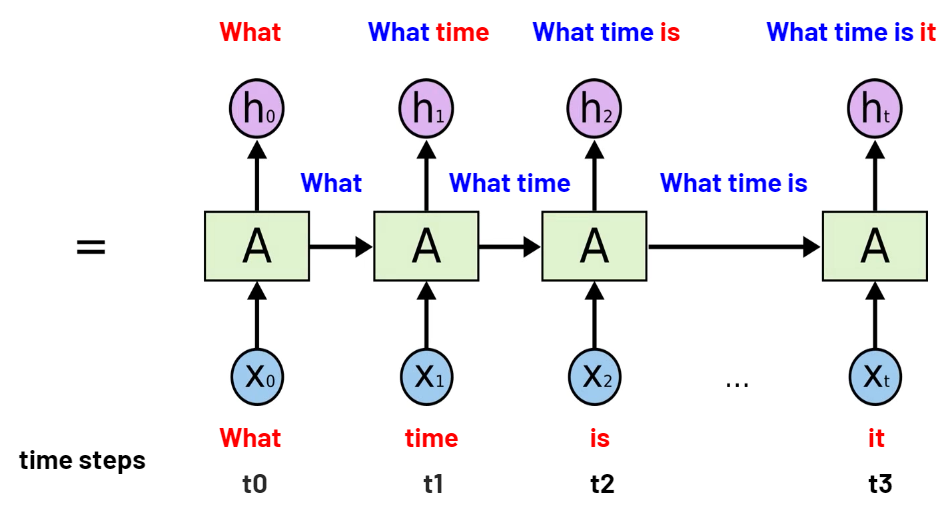

In [119]:
model.add(Embedding(input_dim=num_words, # numarasi sadece 15k'ya olan kadaralara islem yap. 15k altina kesinlikle inmemeli
                    output_dim=embedding_size, # ornegin 1 olan "çok"u 50 boyutlu bir word embeddinge donusturecek
                    input_length=max_tokens)) # modele verilen her bir yorumun uzunlugu max 61 olacak

# NLP RNN modellerinde ilk layerimiz her zaman embedding layer olur
# Embedding layer NLP modellerinde kullanılan bir layer olup 3 boyutlu bir tensörden oluşur. 
# 1'inci boyutu train setindeki toplam yorum sayısı.
# 2'inci boyutu her bir yorumun kaç tokenden oluştuğu (max_tokens).
# 3'üncü boyutu her bir tokene ait word embeddingin kaç elemanlı bir vektörden oluştuğu (embedding_size).
# Yorumlar numeric versiona dönüştürülürken corpusta en sık kullanılan ilk 15000 token kullanıldığından, hem train hem de predicit aşamasında sadece corpusta en sık
# geçen ilk 15000 token kullanılsın diye Embedding layera imput_dim = num_words düzenlemesini yapıyoruz.
# Eğer imput_dim'i 15.000'den daha küçük bir sayı yaparsanız (10000 gibi) o zaman model corpusta en sık kullanılan ilk 10000 token ile eğitim ve prediction yapar.

model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True)) # tavsiye embedding layerla ilk layerda ayni unit oldugundan 50 verdik

# return_sequences=False modelin sadece son zaman adımındaki (t_n) hidden_state'i bir sonraki layera aktarır. defaultu False'dur.
# return_sequences= True,  modelin tüm zaman adımlarındaki (t_0, t_1, t_2 .....t_n gibi) tüm hidden_state'i bir sonraki LSTM, GRU layerlarına aktarır. Bu sayede  model tüm
# cümleyi aklında tutmaya çalışır. Bir LSTM/GRU layerından sonra yine bir LSTM/GRU layerı geliyorsa return_sequences=True olarak ayarlanmalıdır yoksa model hata döndürür. Ancak,
# sonraki layer dense layer ise return_sequences=False düzenlenmelidir aksi durumda model yine hata döndürür. Çünkü Dense layerlar sadece tek bir hidden_state ile çalışır.
model.add(Dropout(0.2)) 

model.add(GRU(units=25, return_sequences=True)) # bir sonraki layer da yine GRU ise true yapilir; eger farkli bir lyer olsa /LSTM, dense vs) o zaman false.
model.add(Dropout(0.2))
# sonraki layer GRU layer olduğundan return_sequences=True olarak düzenledik.

model.add(GRU(units=12, return_sequences=False))
# sonraki layer dense layer olduğundan return_sequences=False olarak düzenledik.


model.add(Dense(1, activation='sigmoid')) # binary classification # dense layer 1den fazla hidden statele calismaaz; bu nednele return seq false yaparak
# en son hidden statei aktaririz sadece

# overfitting varsa layer sayisini artirmaliyiz. ama 5 layeri gecmemek efektif bir tercihtir.

In [120]:
# Dropout işlemi sırasında belirlenen oran, ortalama olarak kaç nöronun kapatılacağını ifade eder. Örneğin dropout(0.5) işlemi sırasında, her iterasyonda yarısı kadar 
# nöron rastgele olarak kapatılır. Ancak bu oran her iterasyonda tam olarak aynı olmayabilir. Örneğin bir iterasyonda 0.3 nöron, diğer iterasyonda 0.7 nöron kapatılabilir. 
# Bu nedenle oran her iterasyonda tahmin edebileceğiniz gibi değişebilir.

In [121]:
optimizer = Adam(learning_rate=0.008) # modelde kullanilacak olan gradient descent algoritmasi. Adam genelde daha iyi sonuclar verir
# overfittinge karsi en etkin yontemleerden birisi lr; default 0.001; 0.008 ile deneme yanilmayla en iyi skorlari elde ettik

In [122]:
model.compile(loss='binary_crossentropy', # entropy siniflarin safligini temisl ediyor; gini impurity/enropy 0'a yakin olmasi ideal. burda da amac min etmek
              optimizer=optimizer,
              metrics=['Recall']) # 1 classina ait skorlari gozlemleyecegiz

# compile (derleme) optimizasyon parametlerini düzenlediğimiz yerdir. 
# compile parametreleri DL modelinin optimizosyon işlemlerinde kullanacağımız gradient descent algortimasının seçimi, loss functinın belirlenmesi
# ve optimizasyon işlemleri sırasında takip edilecek metricleri içerir. Detayları aşağıda olduğu gibidir.
# loss: Modelin optimize edilmesi için kullanılacak kayıp fonksiyonu. Örnek olarak, classification :binary_crossentropy veya categorical_crossentropy, regression:mse gibi.
# optimizer: Modelin ağırlıklarını optimize etmek için kullanılacak olan optimizasyon algoritması. Örnek olarak, SGD, Adam veya RMSprop gibi.
# metrics: Modelin performansını değerlendirmek için kullanılacak olan metrikler. Örnek olarak, accuracy, precision veya recall gibi.

https://stats.stackexchange.com/questions/328926/how-many-parameters-are-in-a-gated-recurrent-unit-gru-recurrent-neural-network

In [123]:
model.summary() 
# embedding_size * num_words ==> 50 * 15001 ==> 750050

# 3 x (n2 + nm + 2n) m= input, n= output (3 = gates sayisi +1 : GRUda 2 gate var: reset-update).. LSTM olsaydi 4 olurdu: 3 gates+1
# (50*50 + 50*50 + 2*50)*3 = 15.300 ==> m = 50, n = 50 
# (25*25 + 50*25 + 2*25)*3 = 5775   ==> m = 50, n = 25
# (12*12 + 25*12 + 2*12)*3 = 1404   ==> m = 24, n = 12
# 12*1 + 1 = 13

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 61, 50)            750050    
                                                                 
 dropout_9 (Dropout)         (None, 61, 50)            0         
                                                                 
 gru_9 (GRU)                 (None, 61, 50)            15300     
                                                                 
 dropout_10 (Dropout)        (None, 61, 50)            0         
                                                                 
 gru_10 (GRU)                (None, 61, 25)            5775      
                                                                 
 dropout_11 (Dropout)        (None, 61, 25)            0         
                                                                 
 gru_11 (GRU)                (None, 12)               

In [124]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_recall", mode="max", 
                           patience = 1, restore_best_weights=True)

# NLP modelleri cok cabuk ogrenip hizlica overfittinge gidebildigi icin en fazla 3-4 epochta durur; bu nedenle early stopa cok gerek olmaz kullanilmaz

In [95]:
# overfittingle mucadelede kullanilabilecek bir diger metot sample weight belirleme. scikitlearn libraryden yapariz:

#from sklearn.utils import class_weight
#classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
#pd.Series(classes_weights).unique()

# ama bu datada sample weight yerine class weight kullanacagiz

In [125]:
weights = {0:0.05, 1:0.95}

https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

In [126]:
model.fit(X_train, y_train, epochs=10, batch_size=256, class_weight=weights,   #sample_weight= classes_weights
         validation_data=(X_test, y_test), callbacks=[early_stop]) 
# batch_size ne kadar buyuk olursa model daha iyi ogrenir; bu nedenle overftting varsa batch_size artirilir

# asagida train datasinin skorlarina bakarsak aslinda loss ve recallun farkli oldugunnu gorecegiz. Bu nedenle buradaki skorlar
# uzerinden NLP'de overfitting var yok karari vermeyecegiz. ML'de oldugu gibi traişn test skorlari karsilastirarak karar verecegiz asagida eval_metrics ile

Epoch 1/10
857/857 [==============================] - 73s 78ms/step - loss: 0.0318 - recall: 0.8731 - val_loss: 0.3243 - val_recall: 0.9335
Epoch 2/10
857/857 [==============================] - 30s 35ms/step - loss: 0.0201 - recall: 0.9318 - val_loss: 0.1870 - val_recall: 0.8509


## Model evaluation

In [127]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,recall,val_loss,val_recall
0,0.031818,0.873091,0.324260,0.933480
1,0.020059,0.931752,0.187017,0.850877


<Axes: >

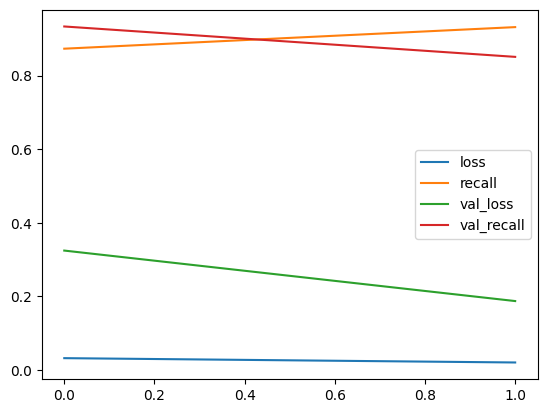

In [128]:
model_loss.plot()

In [129]:
model.evaluate(X_test, y_test)

761/761 [==============================] - 5s 6ms/step - loss: 0.3243 - recall: 0.9335


[0.324260413646698, 0.9334795475006104]

In [130]:
model.evaluate(X_train, y_train)

6849/6849 [==============================] - 37s 5ms/step - loss: 0.3026 - recall: 0.9658


[0.30259767174720764, 0.9657946228981018]

In [131]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

y_pred = model.predict(X_test) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

# neden Cross val yok: DL'de tavsiye edilmez. cunku epochlarla egitim asamasinda zaten bir nevi cv yapiyor

# musterinin tum olusmzu yorumlari yakalamayi istediginiz varsayarak precisionun cok dusuk olmasina onem vermiyoruz
# yukseltmek istersek yukrdaki class weightsi 0.53 0.95 gibi 19 katlik fark yerine ornegin 10 kata indirecek sekilde, daha sonra ornegin
# 7 kata indirecek sekilde yapariz

# make_scorer neden kullanmadik: cunku target class olarak 1i sectik en basta; default 1e bakar; 0 olsun istesek o zaman make scorer ile secerdik

761/761 [==============================] - 5s 5ms/step
[[19767  3215]
 [   91  1277]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     22982
           1       0.28      0.93      0.44      1368

    accuracy                           0.86     24350
   macro avg       0.64      0.90      0.68     24350
weighted avg       0.96      0.86      0.90     24350



In [132]:
y_train_pred = model.predict(X_train) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

6849/6849 [==============================] - 31s 4ms/step
[[179723  27116]
 [   421  11887]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    206839
           1       0.30      0.97      0.46     12308

    accuracy                           0.87    219147
   macro avg       0.65      0.92      0.70    219147
weighted avg       0.96      0.87      0.90    219147



761/761 [==============================] - 4s 5ms/step


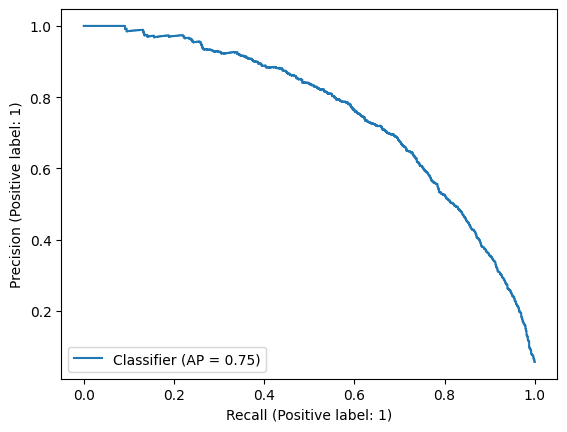

In [133]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test)

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.show();

In [134]:
from sklearn.metrics import precision_recall_curve, average_precision_score

average_precision_score(y_test, y_pred_proba)

0.7513941741645324

## Scores without sample_weight

Test set

                precision    recall  f1-score   support

           0       0.98      0.99      0.98     45965
           1       0.72      0.63      0.67      2735

    accuracy                           0.97     48700
   
 
 
 
 Train set 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    183856
           1       0.87      0.80      0.84     10941

    accuracy                           0.98    194797
   

## Model Saving

In [106]:
#model.save('review_hepsiburada.h5')

##Loading Model

In [107]:
#from tensorflow.keras.models import load_model
#model_review = load_model('/content/drive/MyDrive/review_hepsiburada.h5')

## Predicton

In [108]:
review1 = "çok beğendim herkese tavsiye ederim"
review2 = "süper ürün"
review3 = "büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım"
review4 = "kelimelerle tarif edilemez"
review5 = "tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten"
review6 = "hiç resimde gösterildiği gibi değil"
review7 = "kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım."
review8 = "hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum"
review9 = "tam bir fiyat performans ürünü"
review10 = "beklediğim gibi çıkmadı"
review11 = "on numara beş yıldız"
review12 = "üründe sıkıntı var"
review13 = "televizyonun görüntü kalitesi çok kötü, dün akşam evde arkadaşlarla toplandık. yedik, içtik, sohbet ettik. Sonra televizyonda Türkiye - İngiltere maçını seyrettik."
review14 = '1 gün gibi kısa bir sürede elime geçti. Ve bu fıyata süper bir ürün tavsiye ederim. Lakin eli büyük olan kişiler daha büyük modelini tercih edebilirler ortaboy ürün.Teşekkürler '
review15 = 'telefon kesinlikle bu parayı hak etmiyor. yeni hiç bir özelliği yok. ancak küçük ekran sevenler için iyi bir telefon'
review16 = 'müthiş bir telefon ama bu parayı hak etmiyor'
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14, review15, review16]

# 16 tane yorum için prediction alacağız.

In [109]:
tokens = tokenizer.texts_to_sequences(reviews)

# Öncelikle predict edeceğimiz textleri train datasında olduğu gibi datamızda en fazla kullanılan 15000 tokene göre  numeric versiona dönüştürüyoruz.
# train datasında en sık kullanılan ilk 15000 tokene göre dönüşümler yapıldığından ilk 15000 token dışında kalan tokenler predict aşamasında ignore edilir.

In [110]:
np.array(tokens)

<ipython-input-110-7c9da339794c>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(tokens)


array([list([1, 146, 70, 9, 10]), list([73, 4]),
       list([104, 2, 1032, 2333, 1466, 5, 19, 5, 1779, 11413]),
       list([4212, 11835]),
       list([553, 61, 82, 27, 1, 458, 33, 3, 4, 1032, 2333, 37]),
       list([46, 1096, 6419, 20, 50]),
       list([177, 735, 7728, 82, 263, 105, 326]),
       list([46, 5, 30, 177, 2, 1717, 1244, 4, 1723, 4600, 83]),
       list([74, 2, 28, 111, 19]), list([637, 20, 857]),
       list([395, 179, 1001, 511]), list([447, 147, 34]),
       list([7070, 318, 62, 1, 177, 375, 473, 286, 6559, 1412, 41, 9636, 774]),
       list([38, 40, 20, 108, 2, 161, 29, 150, 3, 5, 2855, 73, 2, 4, 9, 10, 1159, 2430, 104, 113, 2068, 11, 104, 1150, 175, 12730, 4, 16]),
       list([44, 43, 5, 1248, 492, 741, 135, 46, 2, 235, 21, 82, 116, 168, 1598, 8, 6, 2, 44]),
       list([584, 2, 44, 12, 5, 1248, 492, 741])], dtype=object)

In [111]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens, padding="pre")
tokens_pad.shape

# tüm yorumları train datasında olduğu 61 tokene sabitliyoruz.

(16, 61)

In [112]:
prob = model.predict(tokens_pad)
prob

1/1 [==============================] - 0s 41ms/step


array([[0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947],
       [0.5522947]], dtype=float32)

In [113]:
[i[0] for i in prob]

[0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947,
 0.5522947]

In [114]:
pred = (model.predict(tokens_pad) >0.5).astype("int")
pred

1/1 [==============================] - 0s 31ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [115]:
[i[0] for i in pred]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [116]:
pd.set_option('display.max_colwidth', None) # None/-1 ile hücre genişliğini en uzun yoruma/satıra göre ayarlıyor.
my_dict = {"Review":reviews, "prob":[i[0] for i in prob], "classes":[i[0] for i in pred]}
pd.DataFrame(my_dict)

# DataFrame tüm featurların aynı boyutta olmasını istediğinden prob ve classes featurlarını 2 boyuttan tek boyuta düşürüyoruz. 
# Bu sayede tüm featuraler aynı boyutta olmuş oluyor.

,Review,prob,classes
0,çok beğendim herkese tavsiye ederim,0.552295,1
1,süper ürün,0.552295,1
2,büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım,0.552295,1
3,kelimelerle tarif edilemez,0.552295,1
4,tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten,0.552295,1
5,hiç resimde gösterildiği gibi değil,0.552295,1
6,kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım.,0.552295,1
7,hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum,0.552295,1
8,tam bir fiyat performans ürünü,0.552295,1
9,beklediğim gibi çıkmadı,0.552295,1
